[  0%] Reading plotfile /srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary//Plotfiles/Plenum0/plt000000000
[ 33%] Reading plotfile /srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary//Plotfiles/Plenum0/plt000010852
[ 66%] Reading plotfile /srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary//Plotfiles/Plenum0/plt000019933
[100%] Reading plotfile /srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary//Plotfiles/Plenum0/plt000027994


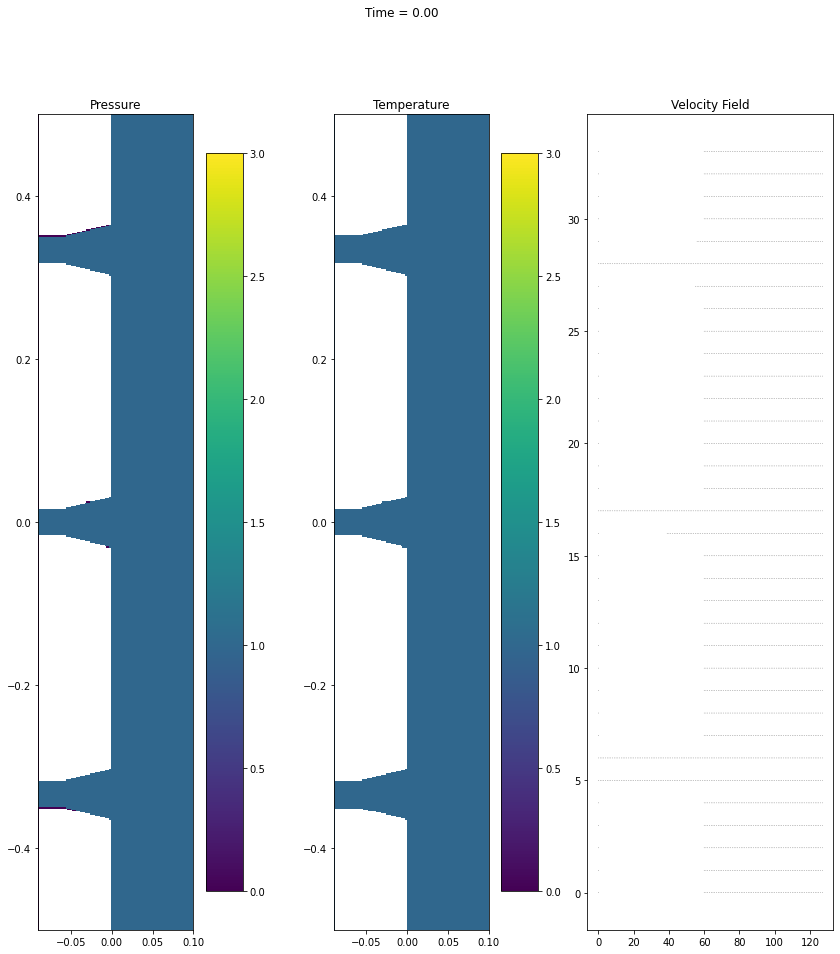

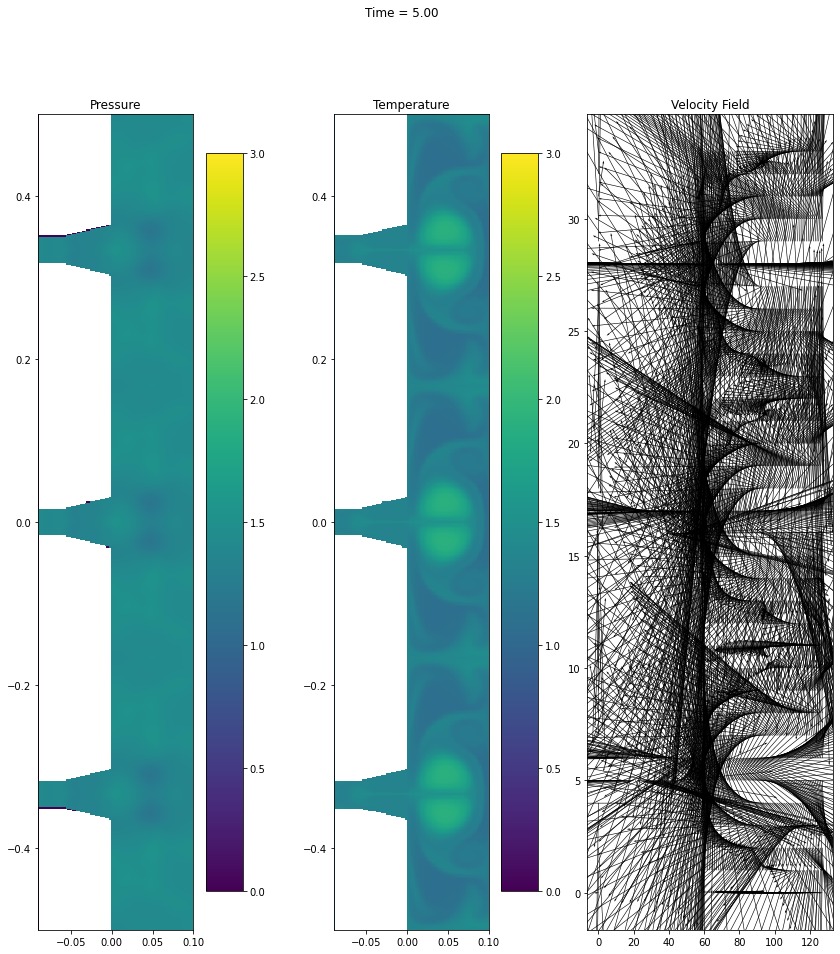

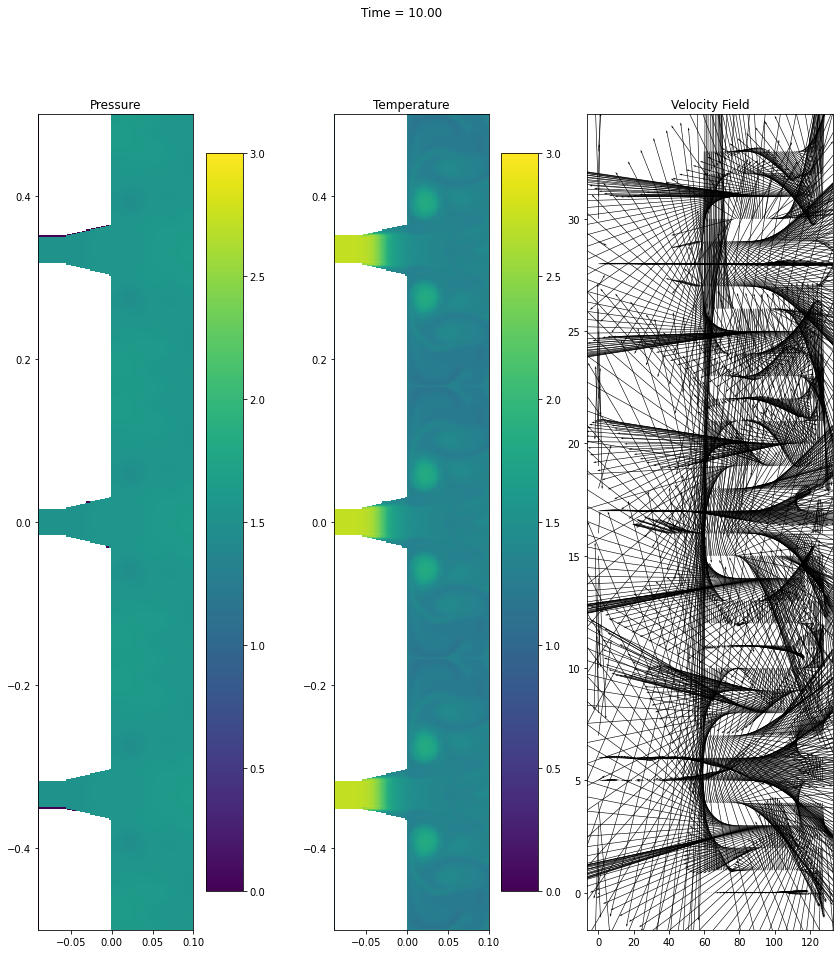

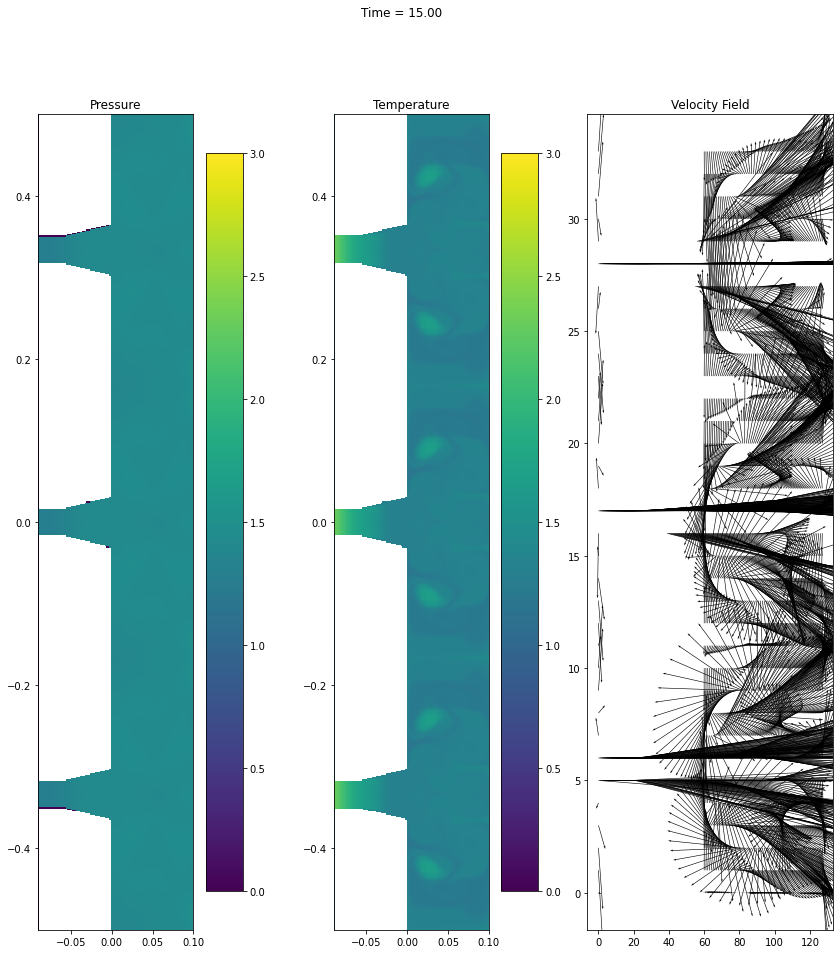

In [3]:
import yt
import os
import numpy as np
import matplotlib.pyplot as plt

valueString = 'Pressure' # which value we want to plot
# possible values are: ['Density', 'Energy', 'Momentum_0', 'Momentum_1', 'Pressure', 'Species_0', 'Species_1', 'SpeedOfSound', 'vfrac']

dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary/"
plenum_number = 0
MASK_DATA_WITH_VFRAC = True
vfrac_cutoff = 1.0e-16

def loadData(plotfile, vars):
  ds = yt.load(plotfile)
  ytplt = yt.plot_2d(ds, vars, origin='native')
  ytplt.set_buff_size((ds.domain_dimensions[0], ds.domain_dimensions[1]))
  ad = ds.all_data()
  current_time = ds.current_time
  datas = [np.squeeze(np.array(ytplt.frb[var])) for var in vars]
  if MASK_DATA_WITH_VFRAC:
    vfrac = np.array(ytplt.frb["vfrac"])
    vfrac = np.squeeze(vfrac)
    datas = [np.ma.masked_where( vfrac<=vfrac_cutoff, data) for data in datas]
  return datas, current_time, np.array(ytplt.bounds)

def PrintProgress(i, plotfiles):
  ny = len(plotfiles)
  progress = int(100.0 * float(i) / (ny - 1))
  print('[{:3d}%] Reading plotfile {}'.format(progress, plotfiles[i]))

yt.funcs.mylog.setLevel(50)
output_dir = dataPath+'/Plotfiles/Plenum%i'%(plenum_number)

dirs = os.listdir(output_dir)
plotfiles = ['{}/{}'.format(output_dir, plt) for plt in dirs]
list.sort(plotfiles)
plotfiles = plotfiles[::500]

output_path = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Pressure")
os.makedirs(output_path, exist_ok=True)

output_path_quiv = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Quiver")
os.makedirs(output_path_quiv, exist_ok=True)

output_path_temp = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Temperature")
os.makedirs(output_path_temp, exist_ok=True)


for i, plotfile in enumerate(plotfiles):
   PrintProgress(i, plotfiles)
   (p, rho, rhou, rhov, c), current_time, extent = loadData(plotfile, ["Pressure", "Density", "Momentum_0", "Momentum_1", "SpeedOfSound"])
   f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
   f.suptitle('Time = {:.2f}'.format(float(current_time)))
   # pressure image
   im_p = axs[0].imshow(p, origin='lower', vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   axs[0].set_title('Pressure')
   plt.colorbar(im_p, ax=axs[0])
   # temperature image
   T = p / rho
   im_T = axs[1].imshow(T, origin='lower', vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   axs[1].set_title('Temperature')
   plt.colorbar(im_T, ax=axs[1])
   # velocity field
   u = rhou / rho
   v = rhov / rho
   skip = 20
   scale = 0.2
   axs[2].quiver(u[::skip], v[::skip], scale=scale, units='xy')
   axs[2].set_title('Velocity Field')
   plt.show()